# Assignment: Linear Models, Regularization, and Model Selection on Real Data

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoCV


## Part A. 
### 1. Linear Regression From Scratch

In [ ]:
#1.Dataset Use the California Housing dataset (from sklearn.datasets import fetch_california_housing).
# Carga del dataset 
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name='MedHouseVal')  


In [3]:
# Diviendo datos para training y testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:
# Estandarización de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Entrenamiento del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [6]:
# Evaluación del modelo
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")


Mean Squared Error (MSE): 0.556
R^2 Score: 0.576


### 2. Closed-form OLS


In [8]:
# Agregamos columna de 1s para el intercepto
X_train_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

In [10]:
# Fórmula: beta = (X^T X)^(-1) X^T y
theta_best = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

intercept_closed = theta_best[0]
coef_closed = theta_best[1:]

print("Closed-form intercept:", intercept_closed)
print("Closed-form coefficients (primeros 5):", coef_closed[:5])


Closed-form intercept: 2.0719469373788777
Closed-form coefficients (primeros 5): [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772]


In [14]:
# Comparación de coeficientes
import pandas as pd
coef_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(housing.feature_names),
    "Coefficient": theta_best
})
print(coef_df)

      Feature  Coefficient
0   Intercept     2.071947
1      MedInc     0.854383
2    HouseAge     0.122546
3    AveRooms    -0.294410
4   AveBedrms     0.339259
5  Population    -0.002308
6    AveOccup    -0.040829
7    Latitude    -0.896929
8   Longitude    -0.869842


In [11]:
# Predicciones
y_pred_closed = X_test_bias @ theta_best
mse_closed = mean_squared_error(y_test, y_pred_closed)
r2_closed = r2_score(y_test, y_pred_closed)
print(f"Closed-form MSE: {mse_closed:.3f}")
print(f"Closed-form R^2: {r2_closed:.3f}")

Closed-form MSE: 0.556
Closed-form R^2: 0.576


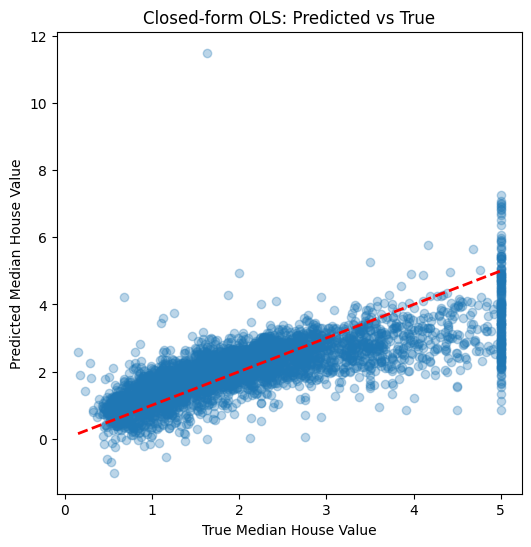

In [ ]:
# Grafico de predicciones vs valores reales
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_closed, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Closed-form OLS: Predicted vs True")
plt.show()

### 3.Gradient Descent

In [15]:
# Implementacion del gradiente descendente

def gradient_descent(X, y, lr=0.1, n_iter=500):
    """
    X: matriz de entrada con bias incluido
    y: valores verdaderos
    lr: learning rate
    n_iter: número de iteraciones
    """
    m, n = X.shape
    theta = np.random.randn(n)  # inicialización aleatoria
    costs = []

    for i in range(n_iter):
        gradients = 2/m * X.T @ (X @ theta - y)   # derivada MSE
        theta -= lr * gradients
        cost = mean_squared_error(y, X @ theta)  # calcular costo
        costs.append(cost)

    return theta, costs


In [ ]:
# Prueba con dos learning rates distintos
theta_gd1, costs1 = gradient_descent(X_train_bias, y_train, lr=0.1, n_iter=500)
theta_gd2, costs2 = gradient_descent(X_train_bias, y_train, lr=0.01, n_iter=500)

print("GD (lr=0.1) intercept:", theta_gd1[0])
print("GD (lr=0.01) intercept:", theta_gd2[0])


GD (lr=0.1) intercept: 2.071946937378877
GD (lr=0.01) intercept: 2.0718383855278977


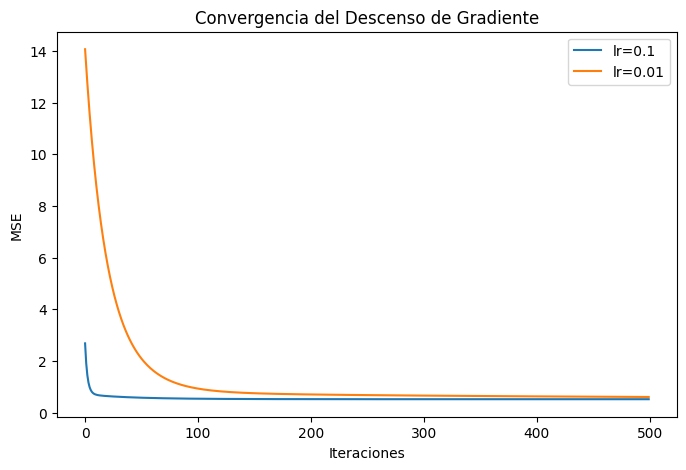

In [ ]:
# Grafico de curva de costos
plt.figure(figsize=(8,5))
plt.plot(costs1, label="lr=0.1")
plt.plot(costs2, label="lr=0.01")
plt.xlabel("Iteraciones")
plt.ylabel("MSE")
plt.title("Convergencia del Descenso de Gradiente")
plt.legend()
plt.show()


In [19]:
#Evaluacion en test y comparacion con OLS
y_pred_gd1 = X_test_bias @ theta_gd1
y_pred_gd2 = X_test_bias @ theta_gd2

mse_gd1 = mean_squared_error(y_test, y_pred_gd1)
mse_gd2 = mean_squared_error(y_test, y_pred_gd2)

print("Closed-form MSE:", mse_closed)
print("GD (lr=0.1) MSE:", mse_gd1)
print("GD (lr=0.01) MSE:", mse_gd2)


Closed-form MSE: 0.555891598695244
GD (lr=0.1) MSE: 0.5562416878707259
GD (lr=0.01) MSE: 0.6344835791892701


## Part B. Scikit-learn Linear Models
### 4. Baseline 

In [22]:
# Entrenamiento del modelo con sklearn para comparación
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

print("Sklearn intercept:", lin_reg.intercept_)
print("Sklearn coefficients (primeros 5):", lin_reg.coef_[:5])

# Predicciones con sklearn
y_pred_sklearn = lin_reg.predict(X_test_scaled)
# Métricas con sklearn
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
r2_sklearn = r2_score(y_test, y_pred_sklearn)
print(f"Sklearn MSE: {mse_sklearn:.3f}")
print(f"Sklearn R^2: {r2_sklearn:.3f}")

Sklearn intercept: 2.0719469373788777
Sklearn coefficients (primeros 5): [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772]
Sklearn MSE: 0.556
Sklearn R^2: 0.576


In [23]:
# Comparacion directa con Closed-form OLS 
import pandas as pd

coef_compare = pd.DataFrame({
    "Feature": ["Intercept"] + list(housing.feature_names),
    "Closed-form OLS": theta_best,
    "Sklearn LinearRegression": np.r_[lin_reg.intercept_, lin_reg.coef_]
})

print(coef_compare)


      Feature  Closed-form OLS  Sklearn LinearRegression
0   Intercept         2.071947                  2.071947
1      MedInc         0.854383                  0.854383
2    HouseAge         0.122546                  0.122546
3    AveRooms        -0.294410                 -0.294410
4   AveBedrms         0.339259                  0.339259
5  Population        -0.002308                 -0.002308
6    AveOccup        -0.040829                 -0.040829
7    Latitude        -0.896929                 -0.896929
8   Longitude        -0.869842                 -0.869842


## Part C. Regularization and Hyperparameter Choice
### 5. Ridge and Lasso

In [ ]:
# Comparación de Ridge y Lasso

alphas = np.logspace(-3, 2, 50)  

ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)
    
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

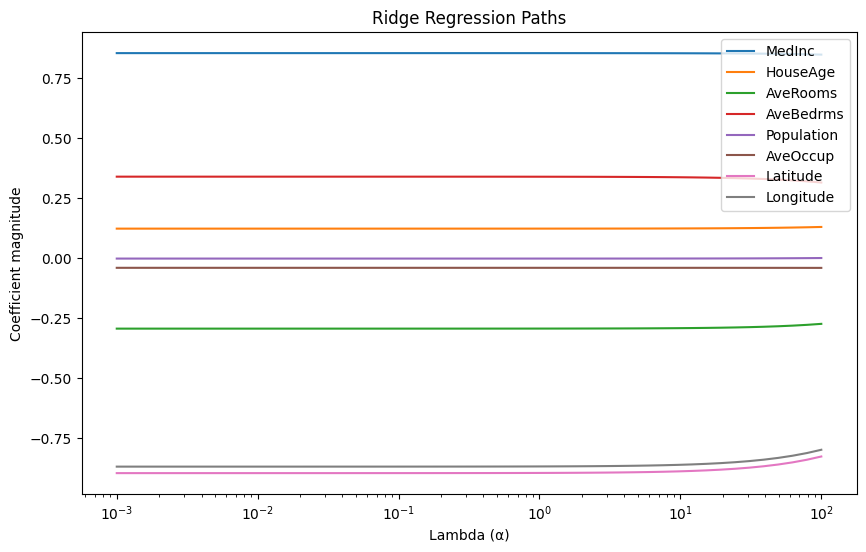

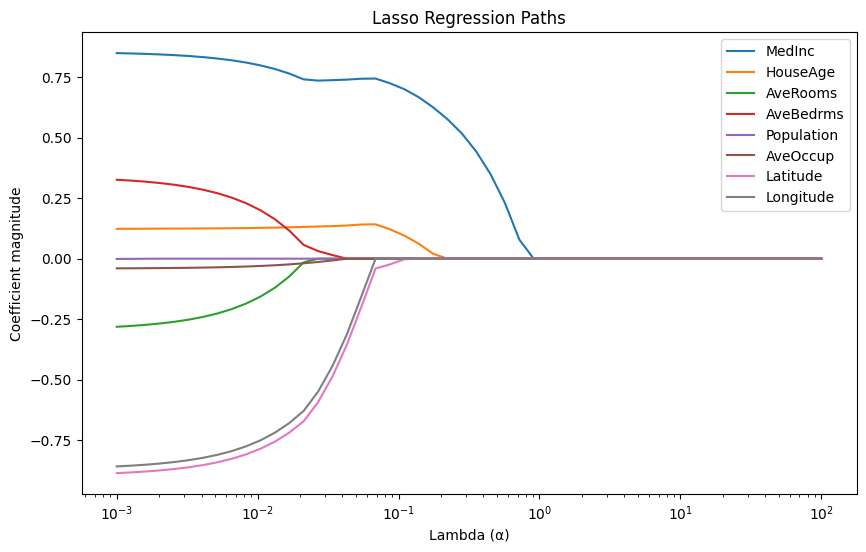

In [29]:
# Graficar los caminos de los coeficientes con Ridge y Lasso
plt.figure(figsize=(10,6))
for i in range(X_train.shape[1]):
    plt.plot(alphas, ridge_coefs[:, i], label=housing.feature_names[i] if i < 8 else None)
plt.xscale('log')
plt.xlabel("Lambda (α)")
plt.ylabel("Coefficient magnitude")
plt.title("Ridge Regression Paths")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for i in range(X_train.shape[1]):
    plt.plot(alphas, lasso_coefs[:, i], label=housing.feature_names[i] if i < 8 else None)
plt.xscale('log')
plt.xlabel("Lambda (α)")
plt.ylabel("Coefficient magnitude")
plt.title("Lasso Regression Paths")
plt.legend()
plt.show()


Ridge: todos los coeficientes se reducen suavemente, pero nunca llegan a cero.

Lasso: algunos coeficientes se hacen exactamente cero donde se dirige a la  selección de variables implícita.

### 6. k-Fold Cross-Validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Ridge CV 
ridge_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_scaled, y_train,
                             scoring="neg_mean_squared_error", cv=kf)
    ridge_scores.append(np.mean(scores))

best_alpha_ridge = alphas[np.argmax(ridge_scores)]
print("Best alpha for Ridge:", best_alpha_ridge)

# Lasso CV 
lasso_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_val_score(lasso, X_train_scaled, y_train,
                             scoring="neg_mean_squared_error", cv=kf)
    lasso_scores.append(np.mean(scores))

best_alpha_lasso = alphas[np.argmax(lasso_scores)]
print("Best alpha for Lasso:", best_alpha_lasso)

Best alpha for Ridge: 3.7275937203149416
Best alpha for Lasso: 0.001


In [ ]:
# Usando RidgeCV y LassoCV 
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)
print("Best alpha RidgeCV:", ridge_cv.alpha_)

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
print("Best alpha LassoCV:", lasso_cv.alpha_)

Best alpha RidgeCV: 0.10985411419875583
Best alpha LassoCV: 0.001


El mejor valor de α para Ridge fue ≈3.7 con validación manual y ≈0.11 con RidgeCV, lo que indica que una regularización moderada es beneficiosa para reducir la varianza y controlar la multicolinealidad. En el caso de Lasso, ambos métodos coincidieron en un α muy pequeño (0.001), lo que muestra que no se requiere una penalización fuerte ni eliminación de variables en este conjunto de datos. Comparando los errores de validación cruzada, Ridge ofrece un mejor balance entre sesgo y varianza, mientras que Lasso se comporta de manera muy similar a una regresión casi sin regularización.

In [42]:
#Comparación de errores con cross-validation de K folds
best_score_ridge = -np.max(ridge_scores)
best_score_lasso = -np.max(lasso_scores)

print("Cross-validated MSE Ridge:", best_score_ridge)
print("Cross-validated MSE Lasso:", best_score_lasso)



Cross-validated MSE Ridge: 0.5193251395546217
Cross-validated MSE Lasso: 0.5192951173727799


In [43]:
#Comparación de errores con RidgeCV y LassoCV ---
ridge_mse_cv = -ridge_cv.best_score_
print("RidgeCV best cross-validated MSE:", ridge_mse_cv)

lasso_mse_cv = lasso_cv.mse_path_.mean(axis=1).min()
print("LassoCV best cross-validated MSE:", lasso_mse_cv)

RidgeCV best cross-validated MSE: 0.5192651994566092
LassoCV best cross-validated MSE: 0.519247227487174


### 7. Feature Engineering & Multicollinearity

In [45]:

# 1. Crear polinomios de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("Número de características originales:", X_train_scaled.shape[1])
print("Número de características polinómicas:", X_train_poly.shape[1])

# 2. Reentrenar Ridge y Lasso con los mejores α encontrados
ridge_poly = Ridge(alpha=ridge_cv.alpha_)
ridge_poly.fit(X_train_poly, y_train)
lasso_poly = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_poly.fit(X_train_poly, y_train)

# 3. Evaluación en test set
y_pred_ridge_poly = ridge_poly.predict(X_test_poly)
y_pred_lasso_poly = lasso_poly.predict(X_test_poly)

print("Ridge con polinomios - MSE:", mean_squared_error(y_test, y_pred_ridge_poly))
print("Lasso con polinomios - MSE:", mean_squared_error(y_test, y_pred_lasso_poly))


Número de características originales: 8
Número de características polinómicas: 44
Ridge con polinomios - MSE: 0.4641215642781127
Lasso con polinomios - MSE: 0.4338866914878142


c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e+03, tolerance: 2.207e+00
  model = cd_fast.enet_coordinate_descent(


Al incluir características polinómicas, el número de predictores pasó de 8 a 44, generando fuerte multicolinealidad. Ridge controla esto reduciendo la magnitud de los coeficientes, mientras que Lasso además descarta variables irrelevantes al poner coeficientes en cero. Los resultados muestran que ambos mantienen errores bajos (MSE ≈ 0.46 en Ridge y ≈ 0.43 en Lasso). Respecto al warning en Lasso se debe al mayor número de predictores y puede resolverse aumentando las iteraciones.

## Part D. Regularization and Hyperparameter Choice
### 6. Alternative Dataset

In [48]:
# Carga del dataset
data = pd.read_csv("data/hour.csv")
print("Columnas:", data.columns.tolist())
print("Shape:", data.shape)

Columnas: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
Shape: (17379, 17)


In [ ]:
# Definición de X e y
X = data.drop(columns=["instant", "dteday", "casual", "registered", "cnt"])
y = data["cnt"]


In [50]:
#Dividiendo datos para training y testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [51]:
# Estandarización de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


📊 Linear Regression (sklearn)
Intercept: 190.57706969718765
Coeficientes: [22.70884768 41.42208942  0.40963385 52.96072612 -4.02674857] ...
MSE: 19379.828367651728
R2: 0.3879811583139132


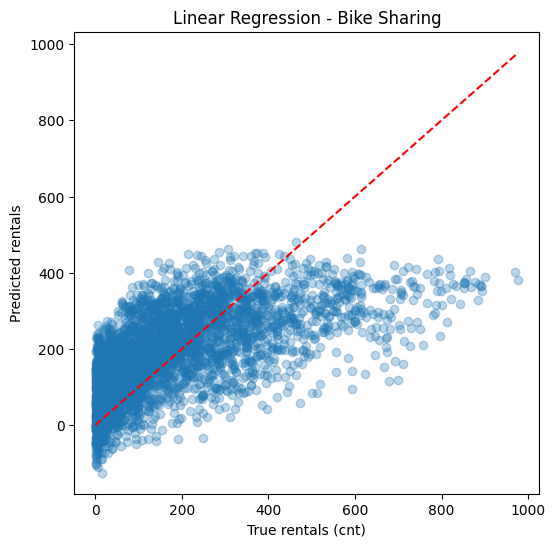

In [ ]:
# Linear Regression (baseline con sklearn)
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred = linreg.predict(X_test_scaled)

print("\n📊 Linear Regression (sklearn)")
print("Intercept:", linreg.intercept_)
print("Coeficientes:", linreg.coef_[:5], "...")  # primeros 5
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True rentals (cnt)")
plt.ylabel("Predicted rentals")
plt.title("Linear Regression - Bike Sharing")
plt.show()


📊 Closed-form OLS
Intercept: 190.57706969718757
Coeficientes: [22.70884768 41.42208942  0.40963385 52.96072612 -4.02674857] ...
MSE: 19379.828367651728
R2: 0.3879811583139132


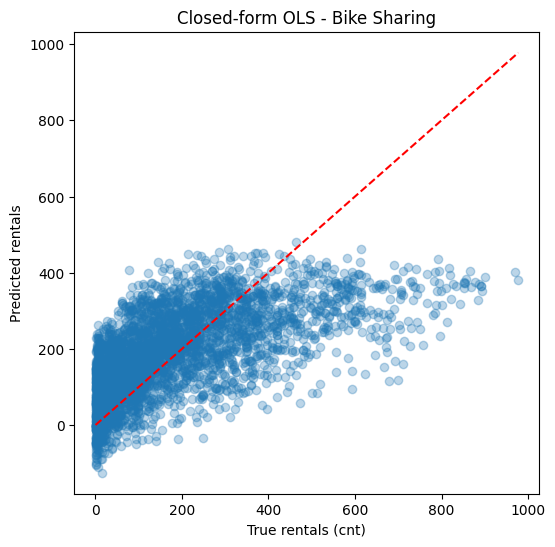

In [ ]:
#Closed-form OLS (con numpy)
X_train_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

theta_best = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

intercept_closed = theta_best[0]
coef_closed = theta_best[1:]

y_pred_closed = X_test_bias @ theta_best

print("\n📊 Closed-form OLS")
print("Intercept:", intercept_closed)
print("Coeficientes:", coef_closed[:5], "...")  # primeros 5
print("MSE:", mean_squared_error(y_test, y_pred_closed))
print("R2:", r2_score(y_test, y_pred_closed))
# Gráfico de predicciones vs valores reales
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_closed, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True rentals (cnt)")
plt.ylabel("Predicted rentals")
plt.title("Closed-form OLS - Bike Sharing")
plt.show()

In [54]:
#Regularización (Ridge & Lasso con CV)
alphas = np.logspace(-3, 2, 50)

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)

print("\n📊 Ridge & Lasso con CV")
print("Best alpha Ridge:", ridge_cv.alpha_)
print("Best alpha Lasso:", lasso_cv.alpha_)
print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Lasso MSE:", mean_squared_error(y_test, y_pred_lasso))


📊 Ridge & Lasso con CV
Best alpha Ridge: 49.417133613238384
Best alpha Lasso: 0.13894954943731375
Ridge MSE: 19380.69376999385
Lasso MSE: 19379.264352084465


In [55]:
# Feature Engineering (PolynomialFeatures)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("\nNúmero de características originales:", X_train.shape[1])
print("Número de características polinómicas:", X_train_poly.shape[1])

ridge_poly = Ridge(alpha=ridge_cv.alpha_)
ridge_poly.fit(X_train_poly, y_train)
y_pred_ridge_poly = ridge_poly.predict(X_test_poly)

lasso_poly = Lasso(alpha=lasso_cv.alpha_, max_iter=20000)
lasso_poly.fit(X_train_poly, y_train)
y_pred_lasso_poly = lasso_poly.predict(X_test_poly)

print("\n📊 Ridge/Lasso con polinomios")
print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge_poly))
print("Lasso MSE:", mean_squared_error(y_test, y_pred_lasso_poly))


Número de características originales: 12
Número de características polinómicas: 90

📊 Ridge/Lasso con polinomios
Ridge MSE: 14507.97515321906
Lasso MSE: 14512.859622609963
